In [ ]:
!nvidia-smi

## 1) Installing libraries

In [1]:
# !pip install transformers
# !pip install datasets
# !pip install wandb
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [3]:
# enter your personal read token

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/TRAC_plus_scrapped", use_auth_token=True)

print(aggression_dataset)

Using custom data configuration IIIT-L--TRAC_plus_scrapped-e37030efaeb75f40
Reusing dataset csv (/home/diptesh/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--TRAC_plus_scrapped-e37030efaeb75f40/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 11390
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1424
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1424
    })
})


In [6]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 11390
})

## 3) Converting to dataframe

In [7]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,I am also lesbian,0
1,I think we should first gather the interested ...,0
2,It should be applicable to every relegion.,1
3,People in Tamilnadu have some sort of inferior...,1
4,where he gone,1


In [8]:
test_df = aggression_dataset['test'][:]

In [9]:
train_df['Label'].value_counts()

0    5144
1    3685
2    2561
Name: Label, dtype: int64

In [10]:
# 11390
# NAG-CAG-OAG (0-1-2) = 0.45-0.32-0.23

Seeing Distribution

In [11]:
disb_df = train_df.copy(deep=True)

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


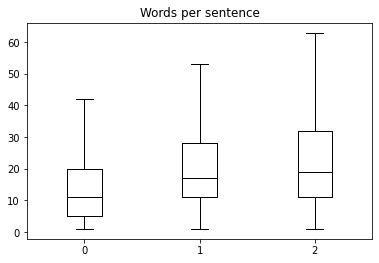

In [12]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [13]:
from transformers import AutoTokenizer

In [14]:
model_ckpt = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
tokenizer.vocab_size

250002

In [16]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [ ]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [ ]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [ ]:
import torch

In [ ]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [ ]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: diptesh. Use `wandb login --relogin` to force relogin


True

In [ ]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
# Defining hyperparameters
eval_batch_size = 16
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-combined-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=6,
                                  learning_rate=4.1187640010910775e-05,
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=8,
                                  weight_decay=0.13668695797323277,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="xlmr-large-combined-DS",
                                  push_to_hub=True)

In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # device = torch.device('cuda')
    # inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.33, 0.46]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/xlm-roberta-large/resolve/main/config.json from cache at /home/diptesh/.cache/huggingface/transformers/4d7a1550c9ab8701667bc307a1213c040fcc06dc87a5e4994e72aecc0d7e0337.842c7737719967568f4691849854475018d6cf7ce21f52576bb6e0d10091bd3c
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-large",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_token_id": 1,

  0%|          | 0/4272 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/transformers/models/roberta/modeling_roberta.py", line 1206, in forward
    outputs = self.roberta(
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/transformers/models/roberta/modeling_roberta.py", line 848, in forward
    encoder_outputs = self.encoder(
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/transformers/models/roberta/modeling_roberta.py", line 524, in forward
    layer_outputs = layer_module(
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/transformers/models/roberta/modeling_roberta.py", line 409, in forward
    self_attention_outputs = self.attention(
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/transformers/models/roberta/modeling_roberta.py", line 336, in forward
    self_outputs = self.self(
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/transformers/models/roberta/modeling_roberta.py", line 238, in forward
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 23.69 GiB total capacity; 21.74 GiB already allocated; 79.88 MiB free; 21.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
trainer.push_to_hub()

## 8) Predictions and Results

In [ ]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [ ]:
preds_output_test = trainer.predict(test_dataset)

In [ ]:
preds_output_test.metrics

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [ ]:
y_valid_test = np.array(test_dataset.labels)

In [ ]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [ ]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

In [ ]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 